In [13]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import concatenate
import numpy as np

from modul.scrap import scrap
from modul.preprocessing import series_to_supervised

from sklearn.metrics import mean_squared_error
from math import sqrt

import pandas as pd

In [2]:
currency = "EURUSD"
interval = "5m"
len_data = "1000"

df = scrap()
df = df[['time','close','open','high','low','ma5','rsi','macd_l','macd_s','tenkan_sen','kijun_sen','chikou_span' ]]

2022-07-01 00:00:00+00:00


e:\SKRIPSI\Forex\modul\scrap.py:51: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  macd = ta.macd(rates_frame['close'].astype(float), length = 10)


(800, 1, 11) (800,) (140, 1, 11) (140,)
Epoch 1/100
25/25 [==============================] - 2s 16ms/step - loss: 0.3249 - val_loss: 0.0704
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.1194
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0753
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0517
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.0318 - val_loss: 0.0274
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0224
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0152 - val_loss: 0.0245
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0144 - val_loss: 0.0241
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.0140 - val_loss: 0.0227
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - 

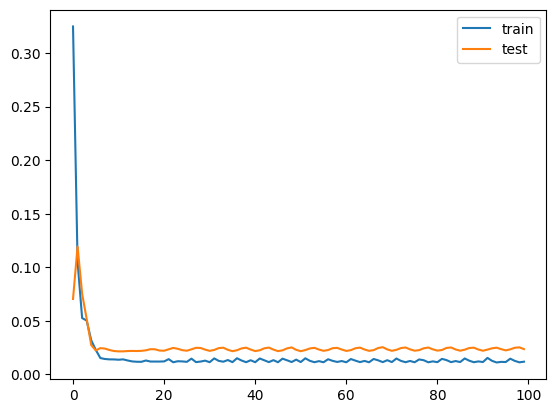

In [15]:
dataset = df
dataset = dataset.set_index('time')

values = dataset.values
values = values.astype('float32')
  # normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed = reframed.iloc[:, 0:(len(dataset.columns)+1)]

# split into train and test sets
values = reframed.values
n_train_hours = 800
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
 # split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=1, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [16]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape = mape(inv_y, inv_yhat)
print('Test MAPE: %.3f' % mape)


5/5 [==============================] - 0s 1ms/step
Test RMSE: 0.001
Test MAPE: 0.052
